## Necessary Libraries

In [1]:
# necessary libraries
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import optimizers

from keras.models import Model, Sequential
from keras import layers

import tensorflow as tf

## Preparing Training and Validation Folders

**dataset format is little bit complex , there is two folder for images , and for their labels there are csv files , therefore  i am gonna create two folder for validation and train and split them**

In [3]:
# no need to execute this for me , i already execute it and i have folders of train and valitons sets
import os
import shutil
import pandas as pd
import random

# /kaggle/input/butterfly-image-classification/train/Image_4378.jpg'

# Read the CSV file (assuming the columns are named "filename" and "label" by default)
csv_file_path = "butterfly dataset/Training_set.csv"
data = pd.read_csv(csv_file_path)

# Creating train and validation directories
root_directory = "kaggle/input"  # Replace with your root directory name

image_dir="butterfly dataset/train" 

train_directory = os.path.join(root_directory, "train")
val_directory = os.path.join(root_directory, "validation")

os.makedirs(train_directory, exist_ok=True)
os.makedirs(val_directory, exist_ok=True)

# Creating label directories
labels = data["label"].value_counts().index


for label in labels:
    label_train_directory = os.path.join(train_directory, label)
    label_val_directory = os.path.join(val_directory, label)
    os.makedirs(label_train_directory, exist_ok=True)
    os.makedirs(label_val_directory, exist_ok=True)

# Shuffle the data
data = data.sample(frac=1).reset_index(drop=True)
# Split the data into 70% train and 30% validation
val_data_count = int(len(data) * 0.3)
validation_data = data[:val_data_count]
train_data = data[val_data_count:]


# Copy train data
for index, row in train_data.iterrows():

    # file name 
    file_name = row['filename']
    # label name
    label = row["label"]

    # images folder , all images are in here  
    source_path = os.path.join(image_dir,file_name) #
    # new destination
    destination_directory = os.path.join(train_directory, label)
    # copy files
    shutil.copy(source_path, destination_directory)
   
    
# Copy validation data
for index, row in validation_data.iterrows():
 
    file_name = row['filename']
    label = row['label']
    
    source_path = os.path.join(image_dir, file_name)
    destination_directory = os.path.join(val_directory, label)
    shutil.copy(source_path, destination_directory)


In [4]:
os.listdir("kaggle/input/train/POPINJAY")[:5]

['Image_1328.jpg',
 'Image_1361.jpg',
 'Image_1388.jpg',
 'Image_1555.jpg',
 'Image_1729.jpg']

In [5]:
os.listdir("kaggle/input/validation/POPINJAY")[:5] # for every class there is different folder for validation and training

['Image_1029.jpg',
 'Image_1199.jpg',
 'Image_1393.jpg',
 'Image_1491.jpg',
 'Image_1566.jpg']

In [7]:
#directories
training_dir="kaggle/input/train"
validation_dir="kaggle/input/validation"

## Distribution of Classes

In [8]:
import os

# directories
train_dir = training_dir
validation_dir = validation_dir

# calculate distribution of classes for train
train_class_counts = {}
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        train_class_counts[class_folder] = num_images

# calculate distribution of classes for valdiation
validation_class_counts = {}
for class_folder in os.listdir(validation_dir):
    class_path = os.path.join(validation_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        validation_class_counts[class_folder] = num_images

print("Training set Distribution:")
print(train_class_counts)

print("Validation set Distribution:")
print(validation_class_counts)

Training set Distribution:
{'ADONIS': 48, 'AFRICAN GIANT SWALLOWTAIL': 56, 'AMERICAN SNOOT': 43, 'AN 88': 62, 'APPOLLO': 63, 'ATALA': 82, 'BANDED ORANGE HELICONIAN': 65, 'BANDED PEACOCK': 61, 'BECKERS WHITE': 59, 'BLACK HAIRSTREAK': 62, 'BLUE MORPHO': 49, 'BLUE SPOTTED CROW': 72, 'BROWN SIPROETA': 66, 'CABBAGE WHITE': 70, 'CAIRNS BIRDWING': 52, 'CHECQUERED SKIPPER': 65, 'CHESTNUT': 63, 'CLEOPATRA': 64, 'CLODIUS PARNASSIAN': 57, 'CLOUDED SULPHUR': 67, 'COMMON BANDED AWL': 60, 'COMMON WOOD-NYMPH': 64, 'COPPER TAIL': 62, 'CRECENT': 64, 'CRIMSON PATCH': 59, 'DANAID EGGFLY': 59, 'EASTERN COMA': 66, 'EASTERN DAPPLE WHITE': 62, 'EASTERN PINE ELFIN': 72, 'ELBOWED PIERROT': 49, 'GOLD BANDED': 51, 'GREAT EGGFLY': 53, 'GREAT JAY': 76, 'GREEN CELLED CATTLEHEART': 56, 'GREY HAIRSTREAK': 63, 'INDRA SWALLOW': 60, 'IPHICLUS SISTER': 67, 'JULIA': 60, 'LARGE MARBLE': 59, 'MALACHITE': 43, 'MANGROVE SKIPPER': 63, 'MESTRA': 54, 'METALMARK': 50, 'MILBERTS TORTOISESHELL': 67, 'MONARCH': 64, 'MOURNING CLOAK':

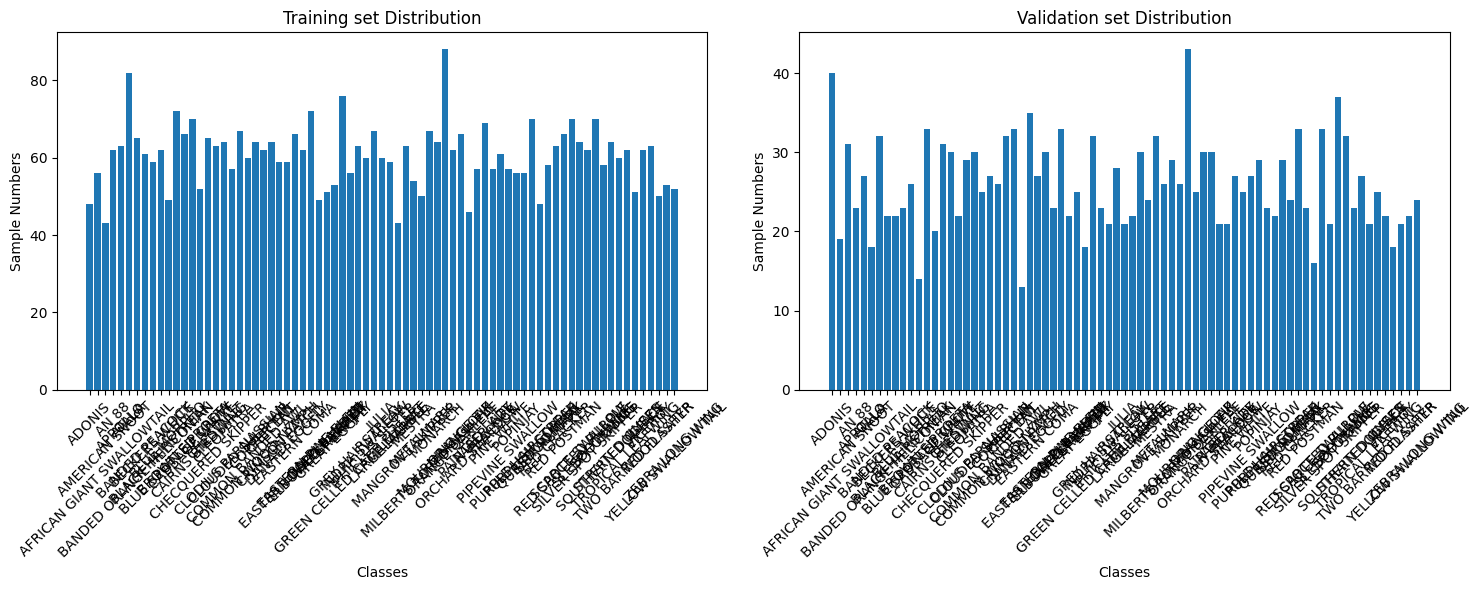

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.bar(train_class_counts.keys(), train_class_counts.values())
plt.title('Training set Distribution')
plt.xlabel('Classes')
plt.ylabel('Sample Numbers')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(validation_class_counts.keys(), validation_class_counts.values())
plt.title('Validation set Distribution')
plt.xlabel('Classes')
plt.ylabel('Sample Numbers')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Creating Datasets ( augmented - not augmented ) For Models

In [10]:
# use this function for preparing data  
def prep_data(augmented,batch_size=16):      # if you want to augmented dat set use it like this : prep_data(True)
    if augmented:                            # default batch_size is 16 , you can change it 
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)
    
        validation_datagen = ImageDataGenerator(rescale=1./255)    

    else:
        train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
        validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

    # training set
    train_set = train_datagen.flow_from_directory(
        training_dir,
        target_size=(180, 180),  # The dimensions to which all images found will be resized
        batch_size=batch_size,# 32  default
        class_mode="sparse") # you can change this to onehotEncoded format or another format
         
    
    # validation set
    validation_set = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(180, 180),
        batch_size=batch_size,  # 32 default
        class_mode="sparse")
             
    return train_set , validation_set

## Function for Viusalization (history)

In [11]:
# visulization function for Models
def visualize(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    axs[0].plot(epochs, acc, 'r', label='Training acc')
    axs[0].plot(epochs, val_acc, 'b', label='Validation acc')
    axs[0].set_title('Training and validation accuracy')
    axs[0].legend()
    axs[0].grid(True)
    
    axs[1].plot(epochs, loss, 'r', label='Training loss')
    axs[1].plot(epochs, val_loss, 'b', label='Validation loss')
    axs[1].set_title('Training and validation loss')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()


# Some example images from Train Dataset 

In [12]:
# not augmented dataset
straight_train_set,validation_set=prep_data(False)

images,labels=straight_train_set.next()

class_names = straight_train_set.class_indices
class_names = {v: k for k, v in class_names.items()}

Found 4550 images belonging to 75 classes.
Found 1949 images belonging to 75 classes.


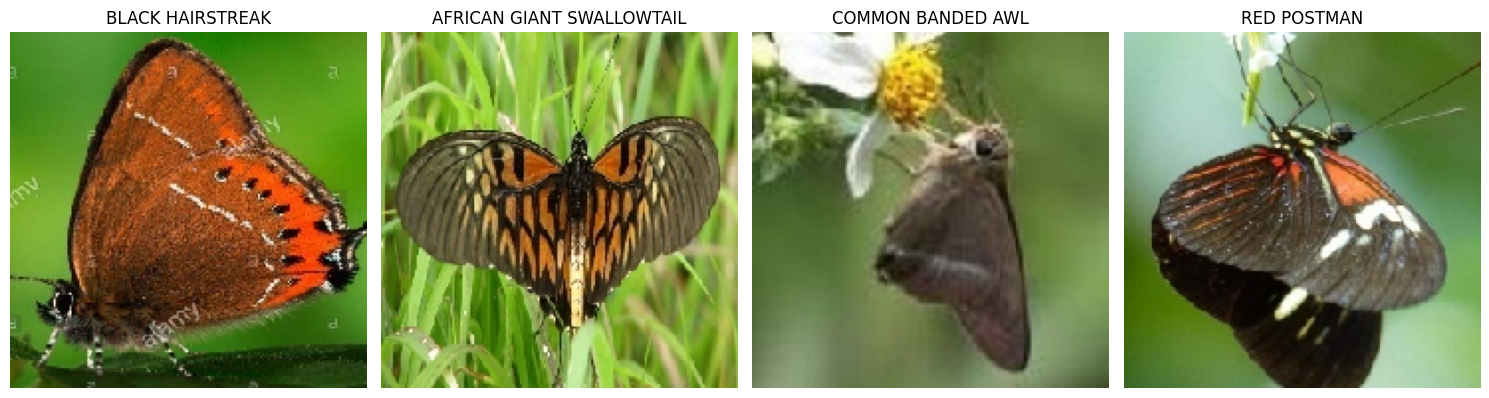

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    axes[i].imshow(images[i]) 
    label_index = int(labels[i])
    class_name = class_names[label_index]
    axes[i].set_title(f"{class_name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Example images from Augmented Set

In [14]:
# augmented dataset
augmented_train_set,validation_set=prep_data(True)
images,labels=augmented_train_set.next()

class_names = augmented_train_set.class_indices
class_names = {v: k for k, v in class_names.items()}

Found 4550 images belonging to 75 classes.
Found 1949 images belonging to 75 classes.


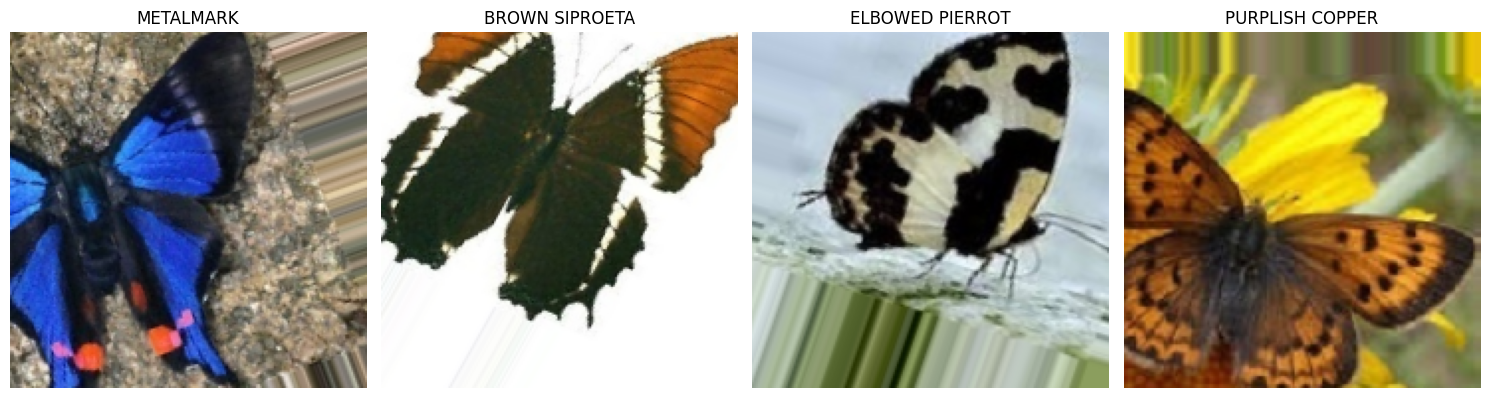

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    axes[i].imshow(images[i]) 
    label_index = int(labels[i])
    class_name = class_names[label_index]
    axes[i].set_title(f"{class_name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Models

## Transfer Learning

In [16]:
# importing pretrained models 
# importing pretrained models 
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception

## InceptionV3 Fine Tuning 

In [17]:
train_set,validation_set=prep_data(True,batch_size=16) # with Data Augmentation

Found 4550 images belonging to 75 classes.
Found 1949 images belonging to 75 classes.


In [18]:
base_model = InceptionV3(weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))



87910968/87910968 [==============================] - 30s 0us/step


In [19]:
# Freeze the layers except the last few layers
for layer in base_model.layers[:-15]:
    layer.trainable = False

In [20]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(75, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00005), 
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 75)                19275     
                                                                 
Total params: 26049515 (99.37 MB)
Trainable params: 4641611 (17.71 MB)
Non-trainable params: 21407904 (81.66 MB)
_________________________________________________________________


In [22]:
fine_tune_inception1_1 = model.fit(
    train_set,
    epochs=15,
    validation_data=validation_set,
    )

Epoch 1/15
285/285 [==============================] - 57s 200ms/step - loss: 0.5492 - accuracy: 0.8407 - val_loss: 0.6741 - val_accuracy: 0.8230
Epoch 2/15
285/285 [==============================] - 59s 206ms/step - loss: 0.5201 - accuracy: 0.8402 - val_loss: 0.6642 - val_accuracy: 0.8220
Epoch 3/15
285/285 [==============================] - 57s 201ms/step - loss: 0.4816 - accuracy: 0.8582 - val_loss: 0.6140 - val_accuracy: 0.8368
Epoch 4/15
285/285 [==============================] - 57s 201ms/step - loss: 0.4556 - accuracy: 0.8604 - val_loss: 0.6255 - val_accuracy: 0.8353
Epoch 5/15
285/285 [==============================] - 56s 196ms/step - loss: 0.4161 - accuracy: 0.8673 - val_loss: 0.6162 - val_accuracy: 0.8358
Epoch 6/15
285/285 [==============================] - 57s 201ms/step - loss: 0.4054 - accuracy: 0.8791 - val_loss: 0.5858 - val_accuracy: 0.8394
Epoch 7/15
285/285 [==============================] - 58s 202ms/step - loss: 0.3756 - accuracy: 0.8877 - val_loss: 0.6537 - val_ac

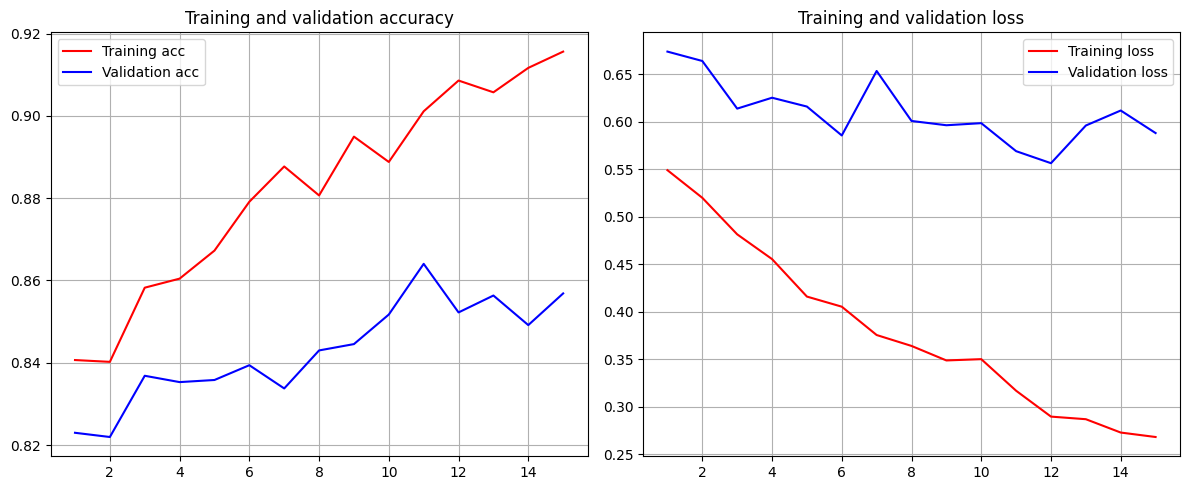

In [23]:
visualize(fine_tune_inception1_1)

overfitting occured , i will try to prevent it in below model

## InceptionV3 Fine Tuning 1_2

In [24]:
train_set,validation_set=prep_data(True,batch_size=16) # with Data Augmentation

Found 4550 images belonging to 75 classes.
Found 1949 images belonging to 75 classes.


In [25]:
base_model = InceptionV3(weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))

In [26]:
# Freeze the layers except the last few layers
for layer in base_model.layers[:-18]:
    layer.trainable = False

In [27]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(90, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00005),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               4194432   
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 90)                23130     
                                                                 
Total params: 26053370 (99.39 MB)
Trainable params: 53

In [29]:
fine_tune_inception1_2 = model.fit(
    train_set,
    epochs=15,
    validation_data=validation_set,
    )

Epoch 1/15
285/285 [==============================] - 59s 206ms/step - loss: 1.2384 - accuracy: 0.6527 - val_loss: 0.8546 - val_accuracy: 0.7809
Epoch 2/15
285/285 [==============================] - 58s 202ms/step - loss: 1.0743 - accuracy: 0.7042 - val_loss: 0.7699 - val_accuracy: 0.7973
Epoch 3/15
285/285 [==============================] - 58s 203ms/step - loss: 0.9618 - accuracy: 0.7358 - val_loss: 0.6867 - val_accuracy: 0.8163
Epoch 4/15
285/285 [==============================] - 59s 208ms/step - loss: 0.8644 - accuracy: 0.7516 - val_loss: 0.6572 - val_accuracy: 0.8256
Epoch 5/15
285/285 [==============================] - 59s 208ms/step - loss: 0.8035 - accuracy: 0.7745 - val_loss: 0.6483 - val_accuracy: 0.8209
Epoch 6/15
285/285 [==============================] - 61s 215ms/step - loss: 0.7107 - accuracy: 0.8022 - val_loss: 0.5799 - val_accuracy: 0.8384
Epoch 7/15
285/285 [==============================] - 129s 454ms/step - loss: 0.6734 - accuracy: 0.8099 - val_loss: 0.6039 - val_a

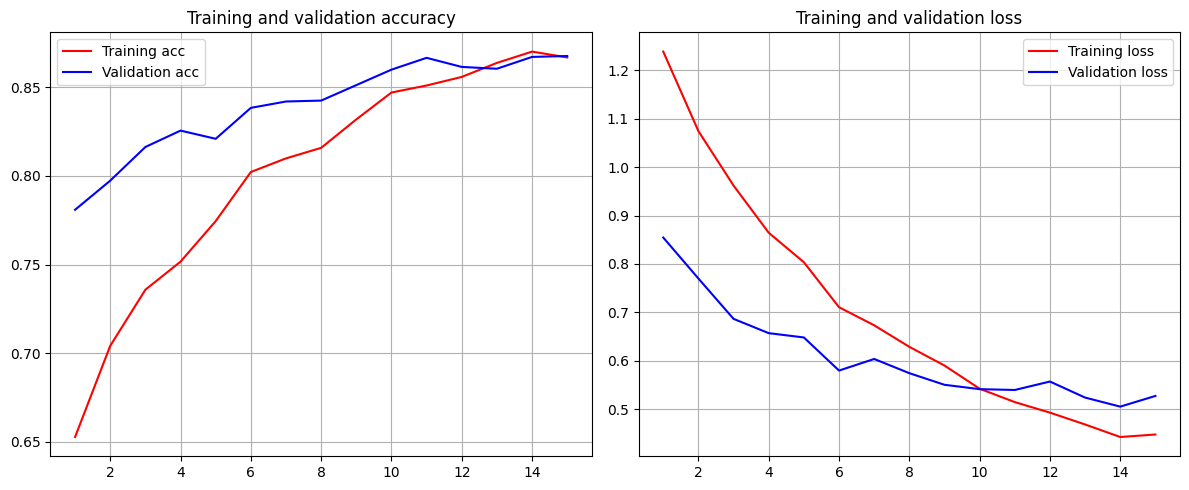

In [30]:
visualize(fine_tune_inception1_2)

curves seems pretty good for now <br>
accuracy: 0.9138 <br>val_accuracy: 0.8851